# TimeSeries Project (e-commerce dataset)

Problems encountered in dataset:
- Columns separated with character (')
- Float separated with comma 
- Totale column with negative values

In [9]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

## Import dataset and formatting types

In [94]:
df = pd.read_csv('.\data\serie-storiche-ecommerce.csv', quotechar="'", parse_dates=["data"])
df["totale"] = df["totale"].apply(lambda x : (x.replace(",", ".")))
df["totale"] = df["totale"].astype(float)
df.sort_values('data', inplace=True)
df.head()

,data,totale,settore
0,2013-02-01,815.97,Calcio
1,2013-02-21,4775.75,Fitness
2,2013-04-01,4775.75,Fitness
3,2013-04-06,1962.15,Casual
4,2013-07-09,1809.87,Basket


In [95]:
### descriptive analysis on total column
df["totale"].describe()

count     25261.000000
mean       7886.239314
std       13273.856514
min       -2159.180000
25%        1335.300000
50%        3948.860000
75%       10209.730000
max      516104.930000
Name: totale, dtype: float64

In [96]:
df.isnull().sum()

data       0
totale     0
settore    0
dtype: int64

In [97]:
df = df[df["totale"]>0]

## Data exploration

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25227 entries, 0 to 25260
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     25227 non-null  datetime64[ns]
 1   totale   25227 non-null  float64       
 2   settore  25227 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 788.3+ KB


In [99]:
### descriptive analysis on total column
df["totale"].describe()

count     25227.000000
mean       7896.953680
std       13279.580998
min           0.270000
25%        1337.210000
50%        3966.870000
75%       10224.470000
max      516104.930000
Name: totale, dtype: float64

In [100]:
### Check for missing days
from datetime import timedelta

### Group by per data to sum total earnings
df_sells_day = pd.DataFrame(df.groupby(by="data", sort=True, as_index=False)["totale"].sum())

list_missing_dates = []
previous_date = df_sells_day['data'][0] - timedelta(days=1)
for date in df_sells_day['data']:
    if date-timedelta(days=1) != previous_date:
        list_missing_dates.append(date)
    previous_date = date

print('Last date with missing previous day: ' + str(list_missing_dates[-1]))

Last date with missing previous day: 2014-02-20 00:00:00


In [101]:
### Keep only days after the 2014-02-20 and discard the last day too (very low value, could be partial data, maybe extracted not at the end of the day)
df_sells_day = df_sells_day[(df_sells_day['data'] > '2014-02-20') & (df_sells_day['data'] < '2022-04-01')]

(15862.0, 19357.0)

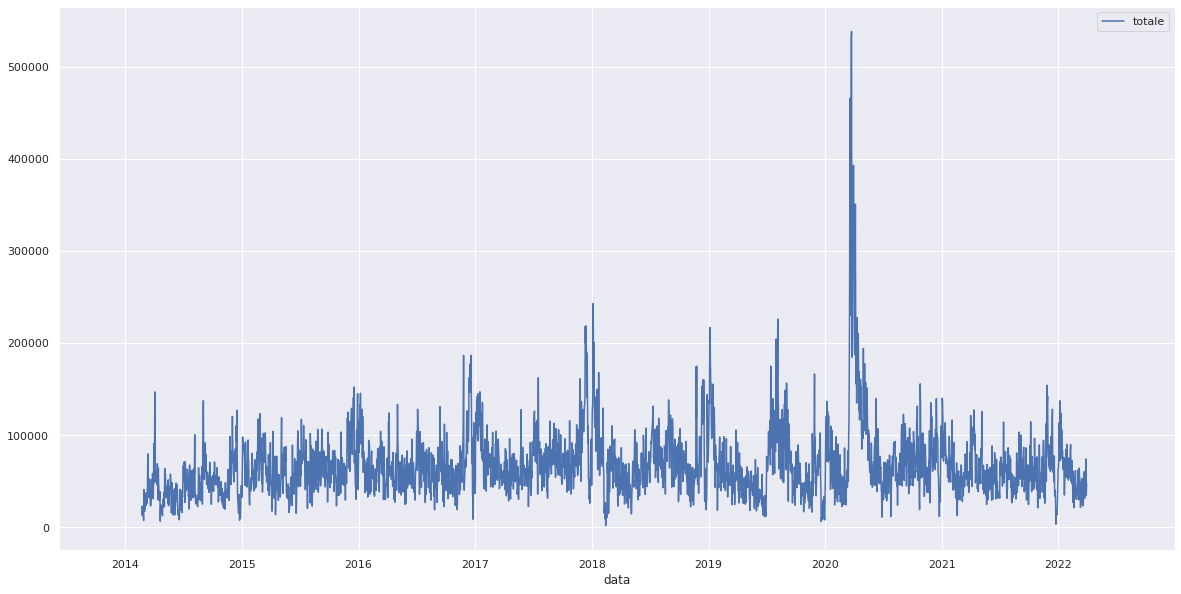

In [102]:
### Plot daily sells
fig, ax = plt.subplots(figsize=(20,10))
df_sells_day.plot(x='data', y='totale', ax=ax)
plt.xlim(left='2013-06-06', right='2022-12-31')

Text(1.0, 1.0, 'Sells per month')

<Figure size 1440x720 with 0 Axes>

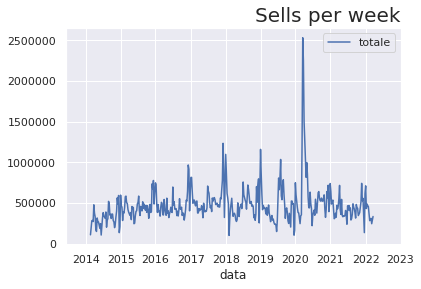

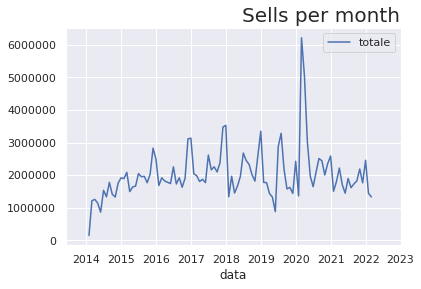

In [103]:
### Group by per data to sum total earnings (1 week and 1 month timeslice)
plt.figure(figsize=(20,10))

# 1 week sum
df_sells_week = pd.DataFrame(df_sells_day.groupby(pd.Grouper(key='data', freq='7d'))['totale'].sum()).reset_index('data')
df_sells_week.plot(x='data', y='totale')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(left='2013-06-06', right='2023-01-01')
plt.title('Sells per week', loc='right', fontdict={'fontsize': 20})

# 1 month sum
df_sells_month = pd.DataFrame(df_sells_day.groupby(pd.Grouper(key='data', freq='1m'))['totale'].sum()).reset_index('data')
df_sells_month.plot(x='data', y='totale')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(left='2013-06-06', right='2023-01-01')
plt.title('Sells per month', loc='right', fontdict={'fontsize': 20})

In [104]:
### Pivot by month
df_sells_day['anno'] = [d.year for d in df_sells_day['data']]
df_sells_day['mese'] = [d.month for d in df_sells_day['data']]

df_mese = pd.DataFrame(df_sells_day.groupby(by=['anno', 'mese'])['totale'].sum()).reset_index()
df_mese = df_mese.pivot(index="mese", columns="anno", values="totale")
df_mese.describe()

anno,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,1.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,3.000000e+00
mean,1.249578e+06,1.938444e+06,1.997196e+06,2.298046e+06,2.147691e+06,1.957926e+06,2.758411e+06,1.855226e+06,1.742187e+06
std,4.496960e+05,3.339884e+05,4.291439e+05,5.327952e+05,6.092255e+05,7.983349e+05,1.431321e+06,3.273135e+05,6.193382e+05
min,1.488231e+05,1.492607e+06,1.627219e+06,1.768157e+06,1.334476e+06,8.785999e+05,1.361682e+06,1.444479e+06,1.330307e+06
25%,1.175879e+06,1.740015e+06,1.737415e+06,1.952222e+06,1.778270e+06,1.436306e+06,1.995257e+06,1.681110e+06,1.386064e+06
50%,1.325950e+06,1.932309e+06,1.860432e+06,2.129405e+06,1.988325e+06,1.695611e+06,2.389943e+06,1.781493e+06,1.441821e+06
75%,1.472324e+06,2.034131e+06,2.002596e+06,2.436196e+06,2.483887e+06,2.350911e+06,2.641094e+06,1.969583e+06,1.948127e+06
max,1.774890e+06,2.825318e+06,3.109826e+06,3.473589e+06,3.526956e+06,3.347046e+06,6.214672e+06,2.585867e+06,2.454433e+06


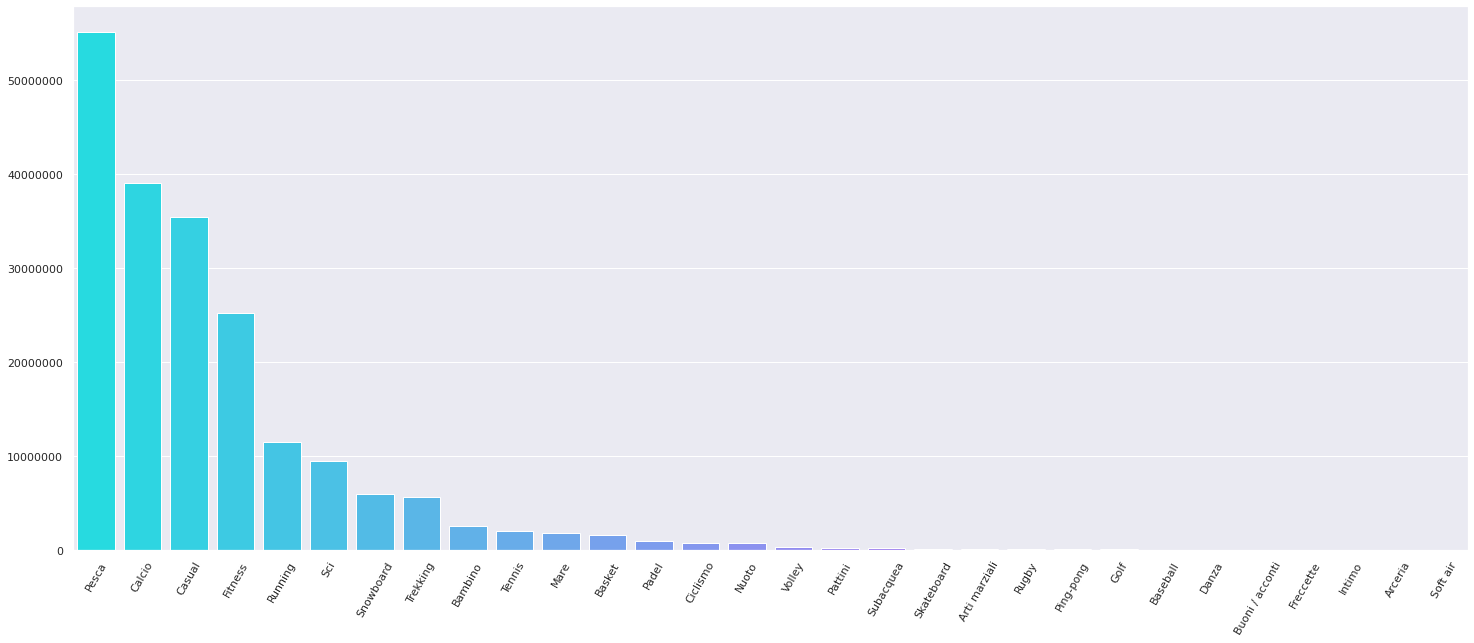

In [105]:
### Group by per category and sum up
df_groupby_settore = df.groupby(by=["settore"], sort=True)["totale"].sum().sort_values(ascending=False)
plt.figure(figsize=(25,10))
plt.xticks(rotation=60)
sns.barplot(x=list(df_groupby_settore.index), y=list(df_groupby_settore.values), palette="cool")
plt.ticklabel_format(style='plain', axis='y')


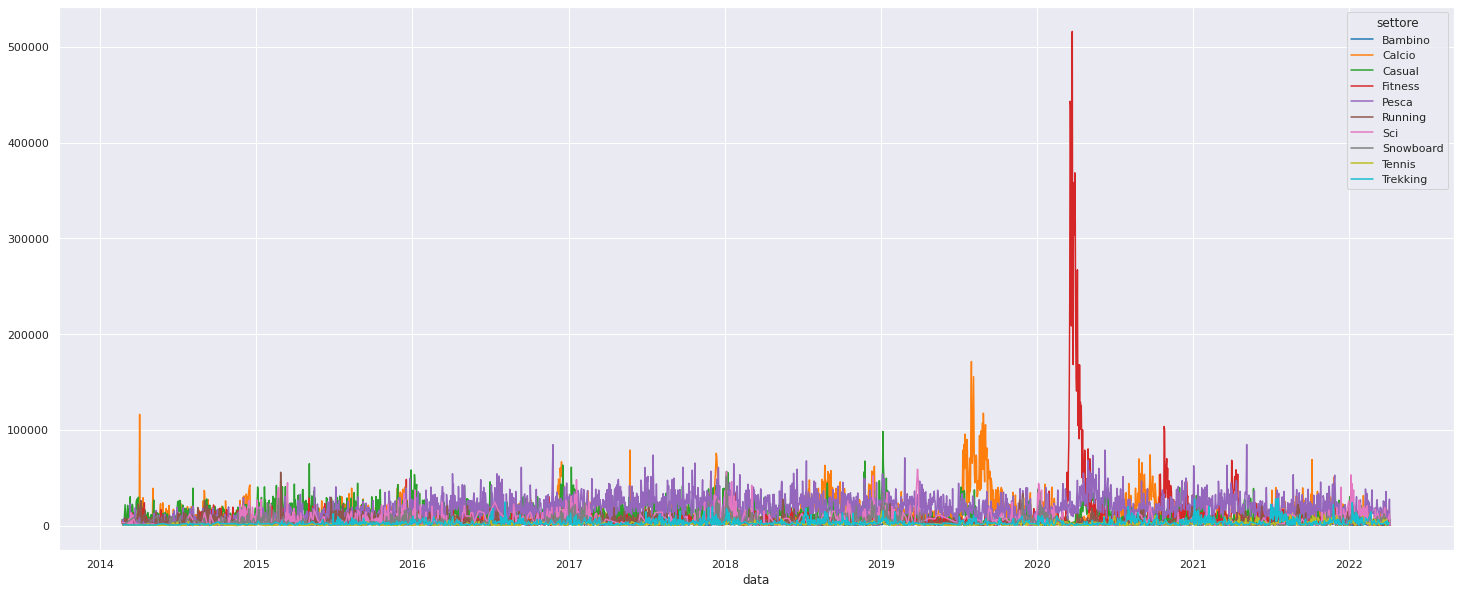

In [106]:
### time series group by higher sectors in total 
list_high_number_total = df_groupby_settore.index[0:10]
df_pivot_settore_and_data = (df[(df['data'] > '2014-02-20') & (df['data'] < '2022-04-08')].query("settore in @list_high_number_total")).pivot(index="data", columns="settore", values="totale")
plt.figure(figsize=(25,10))
sns.lineplot(data=df_pivot_settore_and_data, dashes=False, palette="tab10")

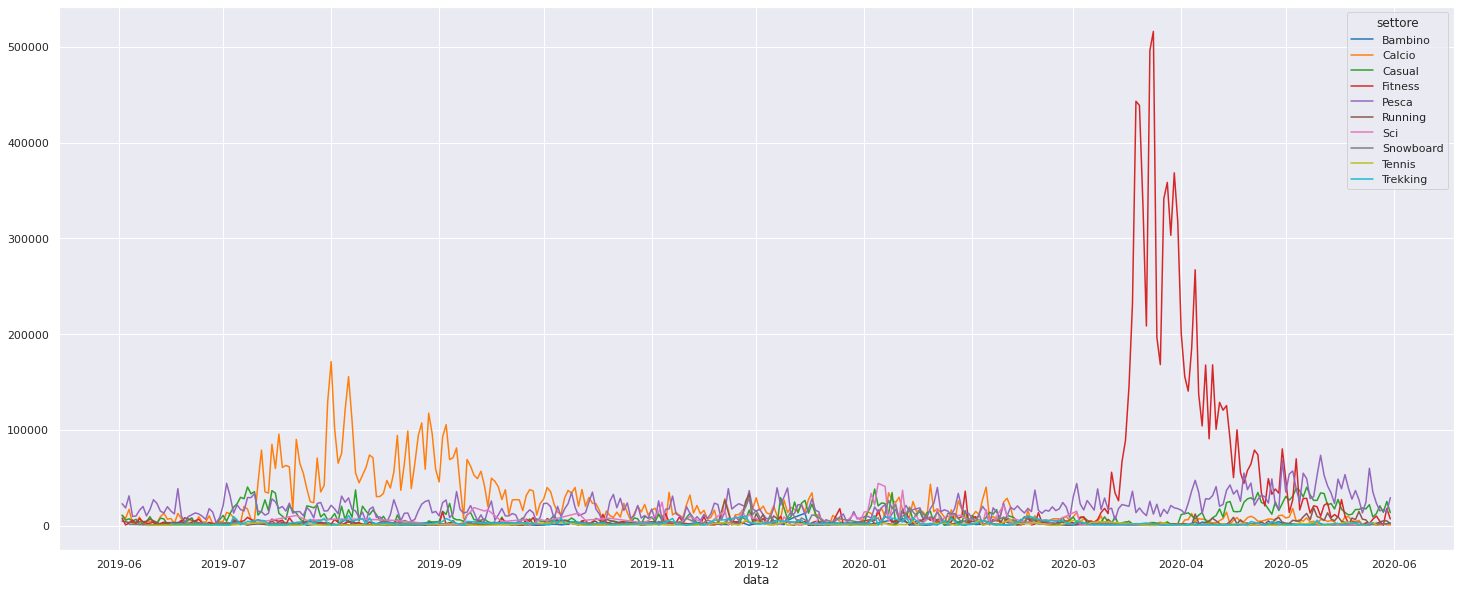

In [107]:
plt.figure(figsize=(25,10))
ax = sns.lineplot(data=df_pivot_settore_and_data[(df_pivot_settore_and_data.index > '2019-06-01') & (df_pivot_settore_and_data.index < '2020-06-01')], dashes=False, palette="tab10")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

In [108]:
df_pivot_settore_and_data.describe()

settore,Bambino,Calcio,Casual,Fitness,Pesca,Running,Sci,Snowboard,Tennis,Trekking
count,1249.000000,2925.000000,2873.000000,2814.000000,2948.000000,2220.000000,1196.000000,1366.000000,972.000000,1514.000000
mean,2084.029736,13309.391921,12305.651730,8930.101446,18643.251957,5126.232239,7872.570886,4355.605007,2039.352294,3764.138137
std,2173.208435,13945.831456,9170.503593,28033.950556,11502.796926,4260.194013,8419.277251,4994.947934,2054.405058,3661.227758
min,81.870000,106.430000,162.100000,45.440000,36.840000,0.270000,2.730000,95.520000,36.840000,121.440000
25%,762.210000,5262.600000,5730.900000,2372.595000,10244.667500,2292.292500,1756.252500,1135.260000,614.030000,1335.300000
50%,1361.770000,9493.650000,10315.620000,4356.575000,16990.345000,3929.760000,5387.050000,2464.970000,1397.930000,2524.870000
75%,2677.150000,16000.400000,16511.810000,7788.430000,25198.020000,6871.755000,10902.360000,5645.072500,2863.402500,4947.202500
max,25858.090000,171365.370000,98255.460000,516104.930000,84700.250000,55733.000000,58780.480000,50980.720000,15268.760000,28574.540000


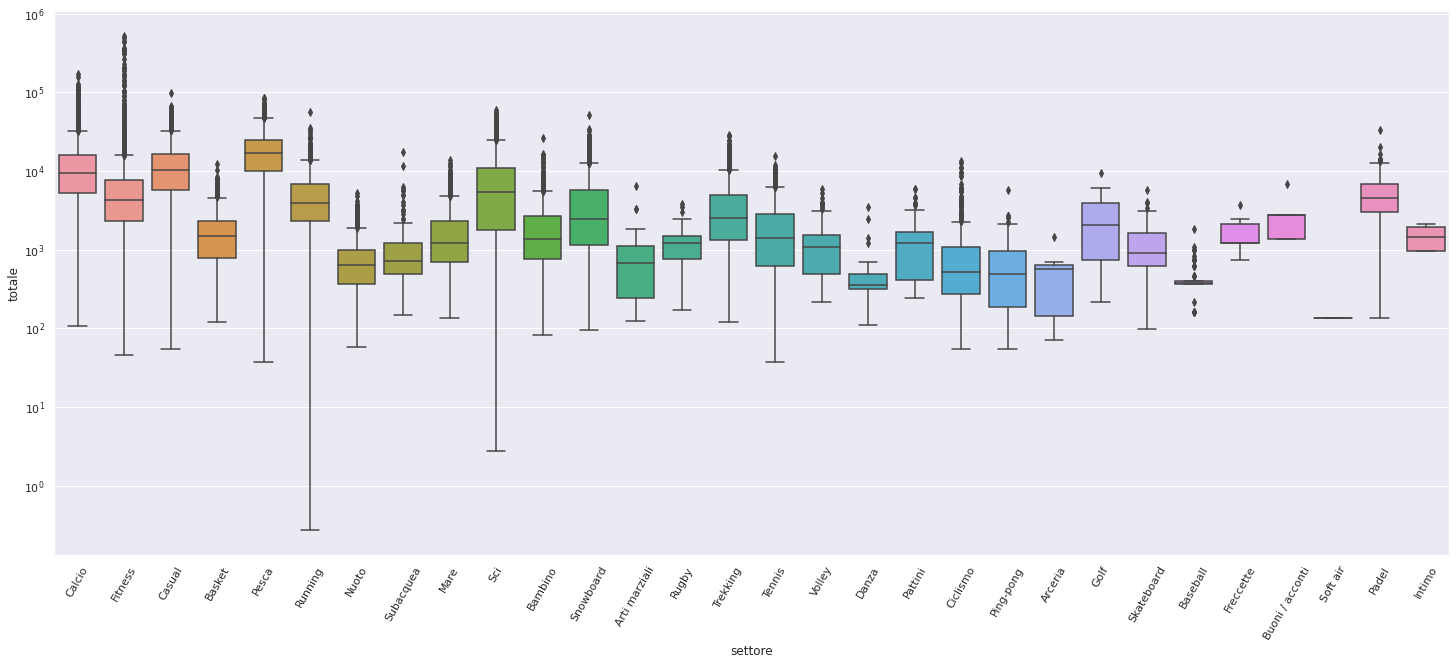

In [109]:
### boxplot to see correlation between cost spent and category
plt.figure(figsize=(25,10))
plt.xticks(rotation=60)
plot = sns.boxplot(data=df, x="settore", y="totale")
plot.set_yscale("log")

## Data integration

In [118]:
from datetime import date, timedelta
from functools import partial
from time import sleep
from calendar import monthrange

import pandas as pd

from pytrends.exceptions import ResponseError
from pytrends.request import TrendReq


def get_last_date_of_month(year: int, month: int) -> date:
    """Given a year and a month returns an instance of the date class
    containing the last day of the corresponding month.
    Source: https://stackoverflow.com/questions/42950/get-last-day-of-the-month-in-python
    """
    return date(year, month, monthrange(year, month)[1])


def convert_dates_to_timeframe(start: date, stop: date) -> str:
    """Given two dates, returns a stringified version of the interval between
    the two dates which is used to retrieve data for a specific time frame
    from Google Trends.
    """
    return f"{start.strftime('%Y-%m-%d')} {stop.strftime('%Y-%m-%d')}"


def _fetch_data(pytrends, build_payload, timeframe: str) -> pd.DataFrame:
    """Attempts to fecth data and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            build_payload(timeframe=timeframe)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return pytrends.interest_over_time()


def get_daily_data(word: str,
                 start_year: int,
                 start_mon: int,
                 stop_year: int,
                 stop_mon: int,
                 geo: str = 'US',
                 verbose: bool = True,
                 wait_time: float = 5.0) -> pd.DataFrame:
    """Given a word, fetches daily search volume data from Google Trends and
    returns results in a pandas DataFrame.
    Details: Due to the way Google Trends scales and returns data, special
    care needs to be taken to make the daily data comparable over different
    months. To do that, we download daily data on a month by month basis,
    and also monthly data. The monthly data is downloaded in one go, so that
    the monthly values are comparable amongst themselves and can be used to
    scale the daily data. The daily data is scaled by multiplying the daily
    value by the monthly search volume divided by 100.
    For a more detailed explanation see http://bit.ly/trendsscaling
    Args:
        word (str): Word to fetch daily data for.
        start_year (int): the start year
        start_mon (int): start 1st day of the month
        stop_year (int): the end year
        stop_mon (int): end at the last day of the month
        geo (str): geolocation
        verbose (bool): If True, then prints the word and current time frame
            we are fecthing the data for.
    Returns:
        complete (pd.DataFrame): Contains 4 columns.
            The column named after the word argument contains the daily search
            volume already scaled and comparable through time.
            The column f'{word}_unscaled' is the original daily data fetched
            month by month, and it is not comparable across different months
            (but is comparable within a month).
            The column f'{word}_monthly' contains the original monthly data
            fetched at once. The values in this column have been backfilled
            so that there are no NaN present.
            The column 'scale' contains the scale used to obtain the scaled
            daily data.
    """

    # Set up start and stop dates
    start_date = date(start_year, start_mon, 1) 
    stop_date = get_last_date_of_month(stop_year, stop_mon)

    # Start pytrends for US region
    pytrends = TrendReq(hl='en-US', tz=360)
    # Initialize build_payload with the word we need data for
    build_payload = partial(pytrends.build_payload,
                            kw_list=[word], cat=0, geo=geo, gprop='')

    # Obtain monthly data for all months in years [start_year, stop_year]
    monthly = _fetch_data(pytrends, build_payload,
                         convert_dates_to_timeframe(start_date, stop_date))

    # Get daily data, month by month
    results = {}
    # if a timeout or too many requests error occur we need to adjust wait time
    current = start_date
    while current < stop_date:
        last_date_of_month = get_last_date_of_month(current.year, current.month)
        timeframe = convert_dates_to_timeframe(current, last_date_of_month)
        if verbose:
            print(f'{word}:{timeframe}')
        results[current] = _fetch_data(pytrends, build_payload, timeframe)
        current = last_date_of_month + timedelta(days=1)
        sleep(wait_time)  # don't go too fast or Google will send 429s

    daily = pd.concat(results.values()).drop(columns=['isPartial'])
    complete = daily.join(monthly, lsuffix='_unscaled', rsuffix='_monthly')

    # Scale daily data by monthly weights so the data is comparable
    complete[f'{word}_monthly'].ffill(inplace=True)  # fill NaN values
    complete['scale'] = complete[f'{word}_monthly'] / 100
    complete[word] = complete[f'{word}_unscaled'] * complete.scale

    return complete

In [ ]:
from pytrends.request import TrendReq
from datetime import datetime

df_trends = get_daily_data(word="Fitness",
                 start_year=2014,
                 start_mon=2,
                 stop_year=2022,
                 stop_mon=3,
                 geo= 'IT',
                 verbose = True)

In [177]:
df_trends.reset_index(inplace=True)
df_trends = df_trends[df_trends["date"] >= "2014-02-21"]
df_trends.set_index("date", inplace=True)
df_trends

,Fitness_unscaled,Fitness_monthly,isPartial,scale,Fitness
date,,,,,
2014-02-21,80,49.0,NaN,0.49,39.20
2014-02-22,51,49.0,NaN,0.49,24.99
2014-02-23,71,49.0,NaN,0.49,34.79
2014-02-24,71,49.0,NaN,0.49,34.79
2014-02-25,77,49.0,NaN,0.49,37.73
...,...,...,...,...,...
2022-03-27,92,41.0,NaN,0.41,37.72
2022-03-28,92,41.0,NaN,0.41,37.72
2022-03-29,75,41.0,NaN,0.41,30.75


##### Correlation complete

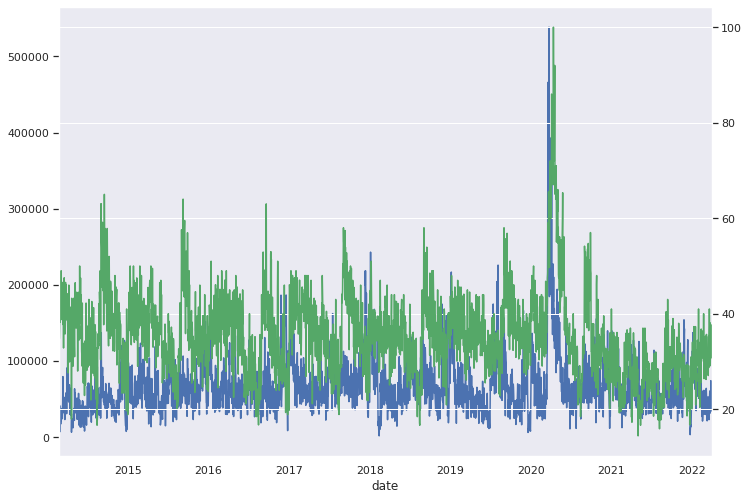

In [180]:
fig,ax = plt.subplots(figsize=(11.7, 8.27))
df_sells_day_tmp.totale.plot(ax = ax, color = 'b')
df_trends.Fitness.plot(ax = ax, secondary_y=True, color ='g')
df_sells_day_tmp = df_sells_day.set_index("data")


In [190]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df_sells_day_tmp["totale"], df_trends["Fitness"])
corr

0.310944923515936

##### Correlation with focus on covid period

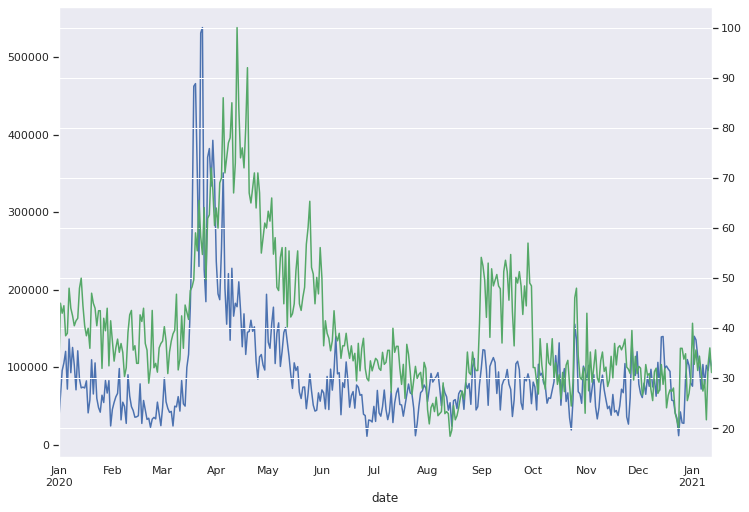

In [191]:
fig,ax = plt.subplots(figsize=(11.7, 8.27))
df_sells_day_tmp['01-01-2020':'01-12-2021'].totale.plot(ax = ax, color = 'b')
df_trends['01-01-2020':'01-12-2021'].Fitness.plot(ax = ax, secondary_y=True, color ='g')
df_sells_day_tmp = df_sells_day.set_index("data")


In [189]:
corr, _ = pearsonr(df_sells_day_tmp['01-01-2020':'01-12-2021']["totale"], df_trends['01-01-2020':'01-12-2021']["Fitness"])
corr

0.5590216026700978

## Time series decomposition

### Decompose daily

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [27]:
df_sells_day_decomp = df_sells_day[(df_sells_day['data'] > '2014-02-20')]
df_sells_day_decomp = df_sells_day_decomp.set_index('data')
df_sells_day_decomp['boxcox'], lam = boxcox(df_sells_day_decomp['totale'])

In [28]:
decompose_day = seasonal_decompose(df_sells_day_decomp['boxcox'], model='add', period=365, extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (20,10)})
decompose_day.plot()
plt.show()
seasonal_decompose()

TypeError: ignored

### Decompose weekly

In [29]:
df_sells_week['boxcox'], lam = boxcox(df_sells_week['totale'])
df_sells_week.set_index('data', inplace=True)

In [30]:
decompose_week = seasonal_decompose(df_sells_week['boxcox'], model='add', period=52, extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (20,10)})
decompose_week.plot()
plt.show()

TypeError: ignored

### Decompose monthly

In [46]:
df_sells_month['boxcox'], lam = boxcox(df_sells_month['totale'])
df_sells_month.set_index('data', inplace=True)

In [31]:
decompose_year = seasonal_decompose(df_sells_month['boxcox'], model='add', period=12, extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (20,10)})
decompose_year.plot()
plt.show()

KeyError: ignored

In this section, we decided to import data regarding the number of searches performed in the given period, in Italy, related to the fitness category. This is because we thought it was interesting to show a correlation between the number of sales and the number of searches on google

## Time series analysis

### Model selection

#### FbProphet

In [33]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [34]:
df_fb = df_sells_week.reset_index().copy()
df_fb.drop(['boxcox'], axis=1, inplace=True)
df_fb.columns = ['ds', 'y']

In [35]:
%%capture
param_grid = {  
    'changepoint_prior_scale': [0.05, 0.5, 1, 5, 10, 20, 30],
    'seasonality_prior_scale': [0.05, 0.5, 1, 5, 10, 20, 30],
    'seasonality_mode': ['multiplicative', 'additive']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_fb[df_fb['ds'] < '2020-03-01'])  # Fit model with given params
    df_cv = cross_validation(m, initial='1460 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

In [36]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results.iloc[np.argmin(mape)])

changepoint_prior_scale               1.0
seasonality_prior_scale               1.0
seasonality_mode           multiplicative
mape                             0.364284
Name: 32, dtype: object


In [37]:
df_fb_train = df_fb[df_fb['ds'] < '2018-06-01']
df_fb_test = df_fb[(df_fb['ds'] >='2018-06-01') & (df_fb['ds'] < '2020-03-01')]

In [38]:
model = Prophet(changepoint_prior_scale=1.0, seasonality_prior_scale=1.0, seasonality_mode='multiplicative')
model.fit(df_fb_train)

In [39]:
forecast = model.predict(df_fb_test)

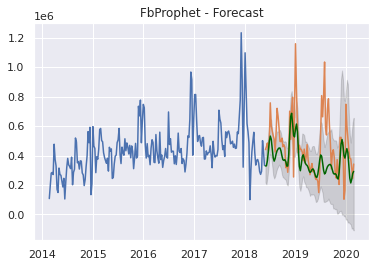

In [40]:
# Plot
plt.plot(df_fb_train.set_index('ds')['y'])
plt.plot(df_fb_test.set_index('ds')['y'])
plt.plot(forecast.set_index('ds')['yhat'], color='darkgreen')
plt.fill_between(forecast.set_index('ds').index, 
                 forecast.set_index('ds')['yhat_lower'], 
                 forecast.set_index('ds')['yhat_upper'], 
                 color='k', alpha=.15)

plt.title("FbProphet - Forecast")
plt.show()

In [41]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)       # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [42]:
forecast_accuracy(np.array(forecast['yhat']), np.array(df_fb_test['y']))

{'corr': 0.5175840863089748,
 'mae': 133277.55329832318,
 'mape': 0.28886325425250275,
 'me': -96151.55664525102,
 'minmax': 0.23977821940376542,
 'mpe': -0.09507596687147028,
 'mse': 35593058220.00892,
 'rmse': 188661.2260640986}

#### SARIMA

In [45]:
import pmdarima as pm

ImportError: ignored

In [ ]:
df_sells_month_train = df_sells_month[df_sells_month.index < '2019-01-01']
df_sells_month_test = df_sells_month[(df_sells_month.index > '2018-12-30') & (df_sells_month.index < '2021-12-31')]

In [ ]:
smodel = pm.auto_arima(df_fb_train['y'], start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=52,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

In [ ]:
# Forecast
n_periods = 92
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)

In [ ]:
# Plot

# make series for plotting purpose
index_of_fc = list(df_fb_test['ds'])
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


plt.plot(df_fb_train.set_index('ds')['y'])
plt.plot(df_fb_test.set_index('ds')['y'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast")
plt.show()

In [ ]:
forecast_accuracy(np.array(fitted), np.array(df_fb_test['y']))

In [ ]:
smodel.plot_diagnostics(figsize=(14,10))
plt.show()

### Test with FbProphet

In [ ]:
from fbprophet import Prophet

In [ ]:
df_fb = df_sells_day.copy()
df_fb.drop(['anno', 'mese'], axis=1, inplace=True)
df_fb.columns = ['ds', 'y']

In [ ]:
df_fb_train = df_fb[df_fb['ds'] < '2020-01-01']
df_fb_test = df_fb[(df_fb['ds'] > '2020-01-01') & (df_fb['ds'] < '2022-01-01')]

In [ ]:
model = Prophet()
model.fit(df_fb_train)

In [ ]:
forecast = model.predict(df_fb_test)

In [ ]:
# Plot
plt.plot(df_fb_train.set_index('ds')['y'])
plt.plot(df_fb_test.set_index('ds')['y'])
plt.plot(forecast.set_index('ds')['yhat'], color='darkgreen')
plt.fill_between(forecast.set_index('ds').index, 
                 forecast.set_index('ds')['yhat_lower'], 
                 forecast.set_index('ds')['yhat_upper'], 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

In [ ]:
model = Prophet()
model.fit(df_fb)

future_dates = pd.date_range(list(df_fb['ds'])[-1], periods = 365, freq='D')
df_future = pd.DataFrame()
df_future['ds'] = future_dates
forecast = model.predict(df_future)

In [ ]:
# Plot
plt.plot(df_fb.set_index('ds')['y'])
plt.plot(forecast.set_index('ds')['yhat'], color='darkgreen')
plt.fill_between(forecast.set_index('ds').index, 
                 forecast.set_index('ds')['yhat_lower'], 
                 forecast.set_index('ds')['yhat_upper'], 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()